# Part 1: Data Exploration
This section focuses on exploring and preparing the dataset for further analysis. The primary objectives are to understand the structure of the data, identify key features, and integrate financial data for subsequent modeling

### Helper Functions

In [2]:
# fetch the mean close data of the 2 days before the event
import pandas as pd
from datetime import datetime, timedelta

def get_two_days_before_event(financial_data, ticker, date_str):
    # Get the DataFrame for the specific ticker
    df = financial_data[ticker].copy()
    df.index = pd.to_datetime(df.index)

    # Convert the input string to a datetime object
    event_date = datetime.strptime(date_str, "%m_%d_%Y")
    
    # Get all dates before the event
    prior_dates = df.index[df.index < event_date]
    
    # Get the two most recent dates before the event
    recent_dates = prior_dates.sort_values()[-2:]
    
    if len(recent_dates) < 2:
        return f"Not enough data before {event_date.date()} for ticker {ticker}"
    
    return df.loc[recent_dates]

def get_data_x_days_after_event(financial_data, ticker, date_str, range):
    # Get the DataFrame for the specific ticker
    df = financial_data[ticker].copy()
    df.index = pd.to_datetime(df.index)

    # Convert the input string to a datetime object
    event_date = datetime.strptime(date_str, "%m_%d_%Y")
    
    # Get all dates after the event
    future_dates = df.index[df.index > event_date]
    
    # Get the two earliest dates after the event
    upcoming_dates = future_dates.sort_values()[:range]
    
    if len(upcoming_dates) < range:
        return f"Not enough data after {event_date.date()} for ticker {ticker}"
    
    return df.loc[upcoming_dates]


def classify_market_caps(market_caps_dict):
    cap_labels = {}
    for ticker, cap in market_caps_dict.items():
        if cap is None:
            cap_labels[ticker] = "Unknown"
        elif cap < 2e9:
            cap_labels[ticker] = "Small Cap"
        elif cap < 10e9:
            cap_labels[ticker] = "Mid Cap"
        else:
            cap_labels[ticker] = "Large Cap"
    return cap_labels

### Load Data

In [3]:
import sqlite3
import json

# Connect to the database
conn = sqlite3.connect("biotech_data.db")
cursor = conn.cursor()

# Enable returning rows as dictionaries (optional, but nice)
conn.row_factory = sqlite3.Row
cursor = conn.cursor()

# Execute the JOIN query
cursor.execute('''
    SELECT 
        articles.id AS article_id,
        article_annotation.annotation_json,
        articles.date,
        company.ticker
    FROM article_annotation
    JOIN articles ON article_annotation.article_id = articles.id
    JOIN company ON articles.company_id = company.id
''')


# Fetch results
rows = cursor.fetchall()

# Convert to list of dictionaries, parsing JSON field
results = []
for row in rows:
    annotation = dict(row)
    annotation["annotation_json"] = json.loads(annotation["annotation_json"])  # Convert JSON string to dict
    results.append(annotation)

# Close the connection
conn.close()


In [4]:
# What is the number of articles in the database?
print(len(results)) 

29306


### Data Exploration

Company to Attend Conference: 5587
Clinical Trial Update or Regulatory Update: 8483
Other: 3836
Press Related to Stock Offerings, Inclusion in Stock Indexes, or Fundraising: 3083
Change in Executive Management or Board of Directors: 1626
Quarterly or Annual Financial Update: 4940
Partnership, Collaboration, or Licensing Agreement: 1612
Legal Dispute: 139


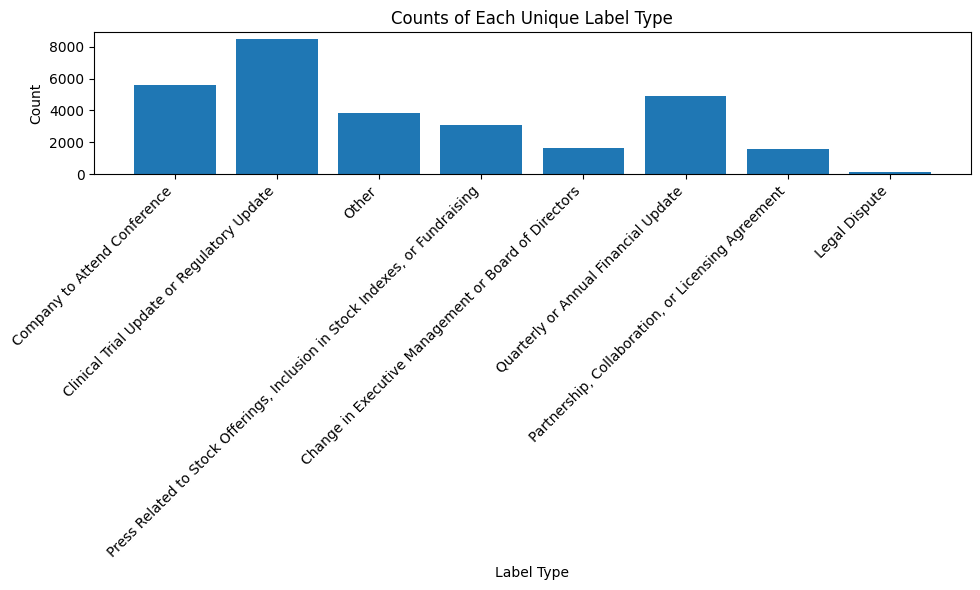

In [5]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Extract labels
labels = [item['annotation_json']['label'] for item in results]

# Correct typo
labels = ['Change in Executive Management or Board of Directors' if label == 'Change in Executive Management or Borad of Directors' else label for label in labels]

# Count occurrences
label_counts = Counter(labels)

# Display the number of press releases for each type
for label, count in label_counts.items():
    print(f"{label}: {count}")

# Create a pandas DataFrame
label_counts_df = pd.DataFrame(label_counts.items(), columns=['press_release_type', 'count'])

# Plot
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label Type')
plt.ylabel('Count')
plt.title('Counts of Each Unique Label Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
label_counts_df.sort_values(by='count', ascending=False)

,press_release_type,count
1,Clinical Trial Update or Regulatory Update,8483
0,Company to Attend Conference,5587
5,Quarterly or Annual Financial Update,4940
2,Other,3836
3,"Press Related to Stock Offerings, Inclusion in...",3083
4,Change in Executive Management or Board of Dir...,1626
6,"Partnership, Collaboration, or Licensing Agree...",1612
7,Legal Dispute,139


In [7]:
# what does the ticker distribution look like?
tickers = [item['ticker'] for item in results]

# Count occurrences
ticker_counts = Counter(tickers)
ticker_counts

Counter({'MRK': 1837,
         'ABBV': 1529,
         'NVS': 1451,
         'AMGN': 1022,
         'REGN': 1017,
         'LLY': 960,
         'BIIB': 939,
         'CYTK': 888,
         'BMRN': 797,
         'ACAD': 619,
         'BBIO': 574,
         'ARWR': 550,
         'KPTI': 542,
         'PTCT': 529,
         'ATRA': 517,
         'GLPG': 507,
         'INSM': 491,
         'RARE': 480,
         'NVAX': 459,
         'FARN': 441,
         'TGTX': 440,
         'ARGX': 411,
         'AGIO': 390,
         'BNTX': 373,
         'MGNX': 373,
         'BPMC': 365,
         'OCUL': 361,
         'TLSA': 356,
         'STRO': 353,
         'FATE': 353,
         'SGMO': 325,
         'KURA': 300,
         'EDIT': 296,
         'MCRB': 296,
         'CTMX': 294,
         'SRPT': 293,
         'XENE': 282,
         'ADMA': 260,
         'CLDX': 260,
         'ASMB': 255,
         'SNDX': 253,
         'VXRT': 248,
         'VKTX': 244,
         'SRRK': 231,
         'ALLO': 215,
        

In [8]:
# how many companies are we looking at? 
len(ticker_counts)

86

Financial Integration

In [9]:
# download historical data for all companies
import yfinance as yf
import pandas as pd
from tqdm import tqdm

financial_data = {}
start_date = "2014-01-01"
end_date = "2025-03-17"  # Adjust as needed

for ticker in tqdm(list(set(tickers))):
    # Fetch historical data
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Keep only Open, High, Low, Close columns
    stock_data = stock_data[['Open', 'High', 'Low', 'Close']]
    financial_data[ticker] = stock_data


  0%|          | 0/86 [00:00<?, ?it/s]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
# assign small cap, mid cap, large cap labels to each ticker
import yfinance as yf

ticker_market_cap = {}

for ticker in tqdm(list(set(tickers))):
    try:
        info = yf.Ticker(ticker).info
        ticker_market_cap[ticker] = info['marketCap']
    except:
        print("error for:", ticker)
        pass


cap_classes = classify_market_caps(ticker_market_cap)

for ticker, label in cap_classes.items():
    print(f"{ticker}: {label}")


 41%|████      | 35/86 [00:10<00:15,  3.39it/s]

error for: AADI


 72%|███████▏  | 62/86 [00:20<00:14,  1.69it/s]

error for: FARN


100%|██████████| 86/86 [00:29<00:00,  2.96it/s]

LEGN: Mid Cap
IPSC: Small Cap
KURA: Small Cap
AMGN: Large Cap
CGEM: Small Cap
MLTX: Mid Cap
CPRX: Mid Cap
KPTI: Small Cap
RXRX: Mid Cap
IGMS: Small Cap
SRPT: Mid Cap
CRMD: Small Cap
ALGS: Small Cap
REGN: Large Cap
MCRB: Small Cap
CRBU: Small Cap
ZYME: Small Cap
BHVN: Mid Cap
BIIB: Large Cap
ETNB: Small Cap
TERN: Small Cap
KRYS: Mid Cap
BEAM: Small Cap
DNLI: Small Cap
DYN: Small Cap
IMVT: Mid Cap
DAWN: Small Cap
RARE: Mid Cap
STRO: Small Cap
RVMD: Mid Cap
MGNX: Small Cap
MGTX: Small Cap
RNA: Mid Cap
MDGL: Mid Cap
BNTX: Large Cap
SRRK: Mid Cap
REPL: Small Cap
NRIX: Small Cap
ATRA: Small Cap
STOK: Small Cap
ABBV: Large Cap
RLAY: Small Cap
RCKT: Small Cap
SANA: Small Cap
ACAD: Mid Cap
SWTX: Mid Cap
ADMA: Mid Cap
GLPG: Small Cap
NVAX: Small Cap
MRK: Large Cap
IOVA: Small Cap
CYTK: Mid Cap
NVS: Large Cap
ARGX: Large Cap
GBIO: Small Cap
EDIT: Small Cap
SLDB: Small Cap
PTCT: Mid Cap
INSM: Large Cap
FATE: Small Cap
OCUL: Small Cap
SGMO: Small Cap
TGTX: Mid Cap
LLY: Large Cap
ALLO: Small Cap
CLD

In [11]:
# add the S&P 500 index as a reference
stock_data = yf.download("SPY", start=start_date, end=end_date)

# Keep only Open, High, Low, Close columns
stock_data = stock_data[['Open', 'High', 'Low', 'Close']]
financial_data['SPY'] = stock_data

[*********************100%***********************]  1 of 1 completed


In [12]:
tickers_with_data = list(financial_data.keys())
# how many could we not fetch?
count = 0
for ticker in list(set(tickers)):
    if ticker not in tickers_with_data:
        count = count + 1

# no missing data
print(count)

0


### Attach Financial Data to Each Event
To measure the effect of the event on the price, we look at the average price of the stock of the 2 days before the event, and then we look at the price of the stock 1 day after the event. This is because the press release could come out the morning of trading or after trading, so if we look at data on the day of the press release, there could be information leakage. By creating a buffer and comparing the price data in the two days before the event, and then 1 day after the event, we can assess the effect of the event with confidence there is no information leakage. 

In [13]:
new_results = []
for result in tqdm(results):
    date = result['date']
    ticker = result['ticker']
    try:
        # Get 2-day pre-event close price
        price_data = get_two_days_before_event(financial_data, ticker, date)
        result['mean_price_minus_2_day_close'] = price_data['Close'][ticker].mean()

        # Get price data for the following two months
        day_list = [1, 7, 14, 21, 30, 38, 45, 53, 60]

        # Get post-event close prices for each day in list
        for day in day_list:
            price_data = get_data_x_days_after_event(financial_data, ticker, date, day)
            result[f'mean_price_plus_{day}_day_close'] = price_data.loc[price_data.index.max(), 'Close'][ticker]

        # Calculate raw return ranges
        for day in day_list:
            result[f'{day}_day_range'] = (result[f'mean_price_plus_{day}_day_close'] - result['mean_price_minus_2_day_close']) / result['mean_price_minus_2_day_close']

        # SPY comparisons (market-adjusted)
        price_data = get_two_days_before_event(financial_data, "SPY", date)
        result['mean_spy_price_minus_2_day_close'] = price_data['Close']["SPY"].mean()

        for day in day_list:
            price_data = get_data_x_days_after_event(financial_data, "SPY", date, day)
            result[f'mean_spy_price_plus_{day}_day_close'] = price_data.loc[price_data.index.max(), 'Close']["SPY"]
            result[f'{day}_day_spy_range'] = (result[f'mean_spy_price_plus_{day}_day_close'] - result['mean_spy_price_minus_2_day_close']) / result['mean_spy_price_minus_2_day_close']
            result[f'adjusted_{day}_day_range'] = result[f'{day}_day_range'] - result[f'{day}_day_spy_range']

        new_results.append(result)

    except Exception as e:
        # Skip bad data points (e.g., delisted tickers, missing prices)
        pass


100%|██████████| 29306/29306 [19:37<00:00, 24.88it/s]


### Which of the events are associated with the most volatility?

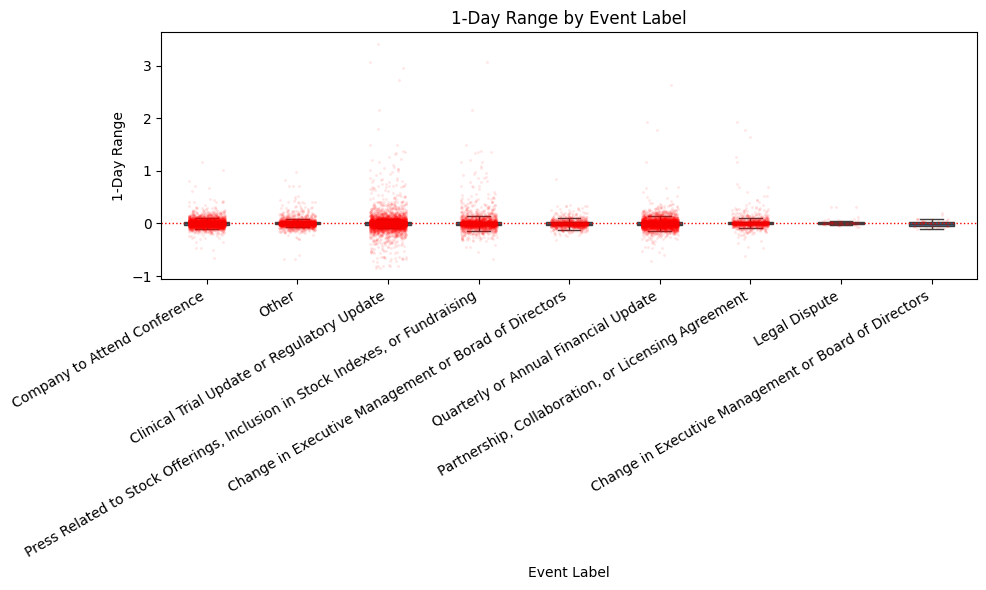

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to DataFrame
df = pd.DataFrame(new_results)

# Extract the label and flatten the structure
df['label'] = df['annotation_json'].apply(lambda x: x.get('label', 'Unknown'))
df['adjusted_1_day_range'] = df['adjusted_1_day_range'].astype(float)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='adjusted_1_day_range', width=0.5, fliersize=0)
sns.stripplot(data=df, x='label', y='adjusted_1_day_range', jitter=0.2, color='red', size = 2, alpha=0.1)
plt.axhline(0, color='red', linestyle='dotted', linewidth=1)

plt.title('1-Day Range by Event Label')
plt.xticks(rotation=30, ha='right')
plt.ylabel('1-Day Range')
plt.xlabel('Event Label')
plt.tight_layout()
plt.show()

# no real difference between these, besides the fact that there are more outliers in clinical trial update / regulatory updates

In [15]:
# Calculate summary stats for each press release type
stats_df = df.groupby('label')['adjusted_1_day_range'].agg(['mean', 'median', 'std', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
stats_df.columns = ['mean', 'median', 'std', 'min', 'max', '25th_percentile', '75th_percentile']
stats_df['count'] = df['label'].value_counts()
stats_df = stats_df.reset_index()
stats_df = stats_df.sort_values(by='std', ascending=False)
stats_df

,label,mean,median,std,min,max,25th_percentile,75th_percentile,count
7,"Press Related to Stock Offerings, Inclusion in...",0.017534,-0.001441,0.163310,-0.673332,3.065537,-0.036009,0.035416,2402
2,Clinical Trial Update or Regulatory Update,0.006826,-0.000266,0.147963,-0.849870,3.423897,-0.022527,0.023950,7247
6,"Partnership, Collaboration, or Licensing Agree...",0.017683,0.003042,0.130761,-0.616836,1.928587,-0.017324,0.028662,1306
8,Quarterly or Annual Financial Update,0.002964,-0.001811,0.102735,-0.715528,2.633243,-0.036001,0.033297,4276
1,Change in Executive Management or Borad of Dir...,-0.001377,-0.005778,0.073036,-0.310005,0.847846,-0.035288,0.020359,1196
5,Other,0.006649,0.000593,0.071558,-0.681751,0.979390,-0.016893,0.021230,3017
3,Company to Attend Conference,0.005604,0.001649,0.070320,-0.656182,1.171123,-0.025438,0.029169,4777
4,Legal Dispute,0.017984,0.007050,0.062017,-0.065337,0.315042,-0.007445,0.020771,90
0,Change in Executive Management or Board of Dir...,0.000976,-0.000739,0.058509,-0.104140,0.200943,-0.042046,0.029190,61


In [16]:
import pandas as pd

def flatten_annotation(row):
    ann = row['annotation_json']
    
    # Copy all top-level keys except 'epidemiology'
    flat = {k: v for k, v in ann.items() if k != 'epidemiology'}
    
    # Handle epidemiology: sum of estimated_incidence across all conditions
    epidemiology = ann.get('epidemiology', {})
    total_incidence = sum(
        v.get('estimated_incidence', 0) 
        for v in epidemiology.values()
        if isinstance(v, dict)
    )
    flat['total_estimated_incidence'] = total_incidence
    
    return pd.Series(flat)

# Apply to your DataFrame
annotation_flat = df.apply(flatten_annotation, axis=1)

# Merge back into the original dataframe (or just use `annotation_flat` as new base)
df_expanded = pd.concat([df.drop(columns=['annotation_json']), annotation_flat], axis=1)

# add market cap labels
df_expanded["market_cap_label"] = df_expanded["ticker"].map(cap_classes)

df_expanded

,article_id,date,ticker,mean_price_minus_2_day_close,mean_price_plus_1_day_close,mean_price_plus_7_day_close,mean_price_plus_14_day_close,mean_price_plus_21_day_close,mean_price_plus_30_day_close,mean_price_plus_38_day_close,...,regulatory_body,result_data,result_fields,result_type,secondary_result_type,therapeutic_areas,title,total_estimated_incidence,year,market_cap_label
0,17043,01_07_2016,REGN,513.570038,491.048981,446.446289,414.577240,390.028778,395.282043,401.424164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Large Cap
1,12111,04_05_2022,MRK,76.630527,77.974930,79.755211,77.525261,80.764664,84.517952,84.453705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Large Cap
2,9145,01_25_2023,ALLO,7.400000,7.830000,7.780000,7.100000,6.190000,5.790000,5.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Small Cap
3,4785,04_07_2024,BBIO,28.125000,28.270000,25.240000,24.330000,28.090000,30.090000,28.850000,...,FDA,NaN,NaN,Positive Results,Conclusion of Phase Result,"[Rare Genetic Diseases, Cardiovascular & Metab...",NaN,20000.0,NaN,Mid Cap
4,12485,05_09_2022,BIIB,197.394997,195.000000,195.710007,206.199997,206.729996,207.000000,212.580002,...,FDA,NaN,NaN,None,None,[Nervous System Diseases],NaN,1600000.0,NaN,Large Cap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24367,24652,04_19_2018,KRYS,10.055000,10.100000,9.610000,10.000000,11.000000,10.300000,13.900000,...,EMA,NaN,NaN,None,None,"[Rare Genetic Diseases, Skin Diseases]",NaN,100.0,NaN,Mid Cap
24368,26327,04_25_2022,NKTX,7.870000,16.790001,19.440001,14.020000,12.350000,14.930000,12.250000,...,None,NaN,NaN,Positive Results,Preliminary or Interim Result,"[Oncology, Hematology]",NaN,140100.0,NaN,Small Cap
24369,28997,05_02_2016,SGMO,6.300000,6.050000,6.020000,6.270000,6.930000,5.990000,5.510000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Small Cap
24370,30402,02_07_2023,STOK,9.470000,9.210000,9.000000,8.890000,8.850000,7.990000,8.220000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Small Cap


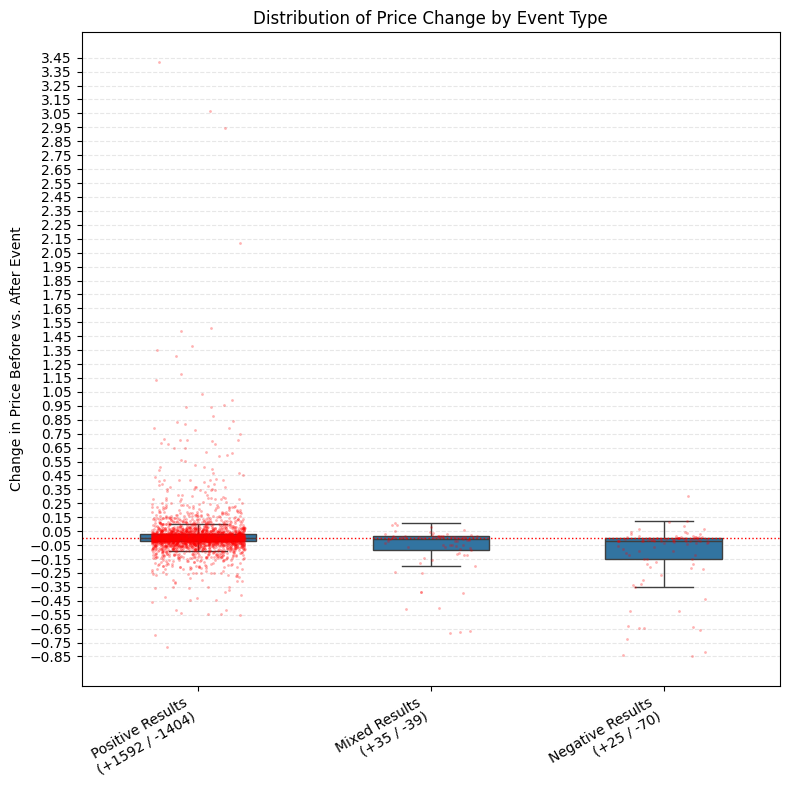

In [17]:
import numpy as np

# Combine "Negative Results - Lack of Efficacy" and "Negative Results - Safety / Adverse Effect" into "Negative Results"
df_expanded['result_type'] = df_expanded['result_type'].replace(
    ['Negative Results - Lack of Efficacy', 'Negative Results - Safety / Adverse Effect'], 
    'Negative Results'
)

# Drill down further
df_subset = df_expanded[df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])]

# Define the desired order for the x-axis
x_order = ['Positive Results', 'Mixed Results', 'Negative Results']

# Calculate counts for positive and negative samples
counts = df_subset.groupby(['result_type', df_subset['1_day_range'] >= 0]).size().unstack(fill_value=0)
counts['Total'] = counts[True] + counts[False]

# Update x-axis labels to include counts
x_labels = [
    f"{label}\n(+{counts.loc[label, True]} / -{counts.loc[label, False]})"
    for label in x_order
]

# Plot
plt.figure(figsize=(8, 8))
sns.boxplot(data=df_subset, x='result_type', y='1_day_range', width=0.5, fliersize=0, order=x_order)
sns.stripplot(data=df_subset, x='result_type', y='1_day_range', jitter=0.2, size=2, color='red', alpha=0.3)
plt.axhline(0, color='red', linestyle='dotted', linewidth=1)

# Set y-ticks at every 0.05 between min and max
ymin, ymax = df['1_day_range'].min(), df['1_day_range'].max()
yticks = np.arange(np.floor(ymin * 20) / 20, np.ceil(ymax * 20) / 20 + 0.1, 0.1)
plt.yticks(yticks)

# Add horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.title('Distribution of Price Change by Event Type')
plt.xticks(ticks=range(len(x_order)), labels=x_labels, rotation=30, ha='right')
plt.ylabel('Change in Price Before vs. After Event')
plt.xlabel('')
plt.tight_layout()
plt.show()

Get the summary stats for this

In [28]:
import pandas as pd
import numpy as np

# Combine "Negative Results - Lack of Efficacy" and "Negative Results - Safety / Adverse Effect" into "Negative Results"
df_expanded['result_type'] = df_expanded['result_type'].replace(
    ['Negative Results - Lack of Efficacy', 'Negative Results - Safety / Adverse Effect'], 
    'Negative Results'
)

# Drill down further
df_subset = df_expanded[df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])]

# Group by result_type and calculate statistics for 1_day_range
stats_df = df_subset.groupby('result_type')['1_day_range'].agg(
    mean='mean',
    median='median',
    std='std',
    percentile_25=lambda x: np.percentile(x, 25),
    percentile_75=lambda x: np.percentile(x, 75)
).reindex(['Positive Results', 'Mixed Results', 'Negative Results'])

# Add counts of positive and negative returns
positive_counts = df_subset[df_subset['1_day_range'] > 0].groupby('result_type').size()
negative_counts = df_subset[df_subset['1_day_range'] <= 0].groupby('result_type').size()

# Add the counts and ratio to the stats_df
stats_df['positive_count'] = positive_counts
stats_df['negative_count'] = negative_counts
stats_df['positive_to_negative_ratio'] = stats_df['positive_count'] / stats_df['negative_count']

# Fill NaN values with 0 for cases where there are no positive or negative samples
stats_df = stats_df.fillna(0)

# Display the table
stats_df

,mean,median,std,percentile_25,percentile_75,positive_count,negative_count,positive_to_negative_ratio
result_type,,,,,,,,
Positive Results,0.016827,0.002125,0.171329,-0.022216,0.026125,1583,1413,1.120311
Mixed Results,-0.077735,-0.008185,0.175897,-0.085165,0.011722,35,39,0.897436
Negative Results,-0.120127,-0.018451,0.233041,-0.149855,0.000612,25,70,0.357143


Look at Phase - which phase is associated with having the most volatile results?

In [29]:
import pandas as pd
import numpy as np

# Ensure the 'phase' column exists and handle missing values
df_expanded['phase'] = df_expanded['phase'].fillna('Unknown')

# Drill down further to include only relevant event types
df_subset = df_expanded[df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])]

# Group by phase and calculate statistics for 1_day_range
stats_df = df_subset.groupby('phase')['1_day_range'].agg(
    mean='mean',
    median='median',
    std='std',
    percentile_25=lambda x: np.percentile(x, 25),
    percentile_75=lambda x: np.percentile(x, 75),
    count='count'  # Add counts column
)

# Calculate counts of positive and negative results for each phase
positive_counts = df_subset[df_subset['1_day_range'] > 0].groupby('phase').size()
negative_counts = df_subset[df_subset['1_day_range'] <= 0].groupby('phase').size()

# Add the counts of positive and negative results to the stats_df
stats_df['positive_count'] = positive_counts
stats_df['negative_count'] = negative_counts

# Add the positive-to-negative ratio column
stats_df['positive_to_negative_ratio'] = stats_df['positive_count'] / stats_df['negative_count']

# Fill NaN values with 0 for cases where there are no positive or negative samples
stats_df = stats_df.fillna(0)

# Sort by standard deviation for better readability
stats_df = stats_df.sort_values(by='std', ascending=False)

# Display the table
stats_df

,mean,median,std,percentile_25,percentile_75,count,positive_count,negative_count,positive_to_negative_ratio
phase,,,,,,,,,
Independent,0.017843,0.000939,0.218463,-0.025430,0.028672,2119,1084,1035,1.047343
Unknown,0.023664,-0.001941,0.206987,-0.041844,0.063460,146,71,75,0.946667
Partnership,0.002105,0.002962,0.103017,-0.020805,0.022340,1264,685,579,1.183074


In [20]:
df_expanded.columns

Index(['article_id', 'date', 'ticker', 'mean_price_minus_2_day_close',
       'mean_price_plus_1_day_close', 'mean_price_plus_7_day_close',
       'mean_price_plus_14_day_close', 'mean_price_plus_21_day_close',
       'mean_price_plus_30_day_close', 'mean_price_plus_38_day_close',
       'mean_price_plus_45_day_close', 'mean_price_plus_53_day_close',
       'mean_price_plus_60_day_close', '1_day_range', '7_day_range',
       '14_day_range', '21_day_range', '30_day_range', '38_day_range',
       '45_day_range', '53_day_range', '60_day_range',
       'mean_spy_price_minus_2_day_close', 'mean_spy_price_plus_1_day_close',
       '1_day_spy_range', 'adjusted_1_day_range',
       'mean_spy_price_plus_7_day_close', '7_day_spy_range',
       'adjusted_7_day_range', 'mean_spy_price_plus_14_day_close',
       '14_day_spy_range', 'adjusted_14_day_range',
       'mean_spy_price_plus_21_day_close', '21_day_spy_range',
       'adjusted_21_day_range', 'mean_spy_price_plus_30_day_close',
       '30_da

Look at regulatory action type and distribution

In [30]:
import pandas as pd
import numpy as np

# # Ensure the 'phase' column exists and handle missing values
# df_expanded['phase'] = df_expanded['regulatory_action_type'].fillna('Unknown')

# # Normalize the 'phase' column to collapse similar values
# df_expanded['phase'] = df_expanded['phase'].str.strip().str.lower()

# # Define a mapping dictionary to collapse similar values
# phase_mapping = {
#     'orphan drug designation': 'fast track, orphan, priority review, or similar designation from regulatory body',
#     'orphan drug designation (odd)': 'fast track, orphan, priority review, or similar designation from regulatory body',
#     'breakthrough therapy designation': 'fast track, orphan, priority review, or similar designation from regulatory body',
#     'breakthrough therapy designation (btd)': 'fast track, orphan, priority review, or similar designation from regulatory body',
#     'priority review': 'fast track, orphan, priority review, or similar designation from regulatory body',
#     'priority review designation': 'fast track, orphan, priority review, or similar designation from regulatory body',
#     # Add other mappings as needed
# }

# Apply the mapping to the 'phase' column
# df_expanded['phase'] = df_expanded['phase'].replace(phase_mapping)

df_expanded['phase'] = df_expanded['partnership_status']


# Drill down further to include only relevant event types
df_subset = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == 'Positive Results')
]

# Group by phase and calculate statistics for 1_day_range
stats_df = df_subset.groupby('phase')['1_day_range'].agg(
    mean='mean',
    median='median',
    std='std',
    percentile_25=lambda x: np.percentile(x, 25),
    percentile_75=lambda x: np.percentile(x, 75),
    count='count'  # Add counts column
)

# Calculate counts of positive and negative results for each phase
positive_counts = df_subset[df_subset['1_day_range'] > 0].groupby('phase').size()
negative_counts = df_subset[df_subset['1_day_range'] <= 0].groupby('phase').size()

# Add the counts of positive and negative results to the stats_df
stats_df['positive_count'] = positive_counts
stats_df['negative_count'] = negative_counts

# Add the positive-to-negative ratio column
stats_df['positive_to_negative_ratio'] = stats_df['positive_count'] / stats_df['negative_count']

# Fill NaN values with 0 for cases where there are no positive or negative samples
stats_df = stats_df.fillna(0)

# Sort by standard deviation for better readability
stats_df = stats_df.sort_values(by='std', ascending=False)

# Display the table, only look at those items with at least 20 samples (ignore low count, noisy rows)
filtered_stats_df = stats_df[stats_df['count'] >= 20]
filtered_stats_df.sort_values(by='positive_to_negative_ratio', ascending=False)

,mean,median,std,percentile_25,percentile_75,count,positive_count,negative_count,positive_to_negative_ratio
phase,,,,,,,,,
Partnership,0.004525,0.003228,0.090615,-0.019386,0.021941,1101,603,498,1.210843
Independent,0.022915,0.001462,0.202802,-0.023179,0.027642,1797,934,863,1.082271


In [31]:
import pandas as pd
import numpy as np

# Drill down further to include only relevant event types and positive results
df_subset = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == 'Positive Results')
]

# Remove duplicate columns if any
df_subset = df_subset.loc[:, ~df_subset.columns.duplicated()]

# Explode the 'drug_modalities' column to handle lists
df_subset = df_subset.explode('drug_modalities')

# Group by drug modalities and calculate statistics for 1_day_range
stats_df = df_subset.groupby('drug_modalities')['1_day_range'].agg(
    mean='mean',
    median='median',
    std='std',
    percentile_25=lambda x: np.percentile(x, 25),
    percentile_75=lambda x: np.percentile(x, 75),
    count='count'  # Add counts column
)

# Calculate counts of positive and negative results for each drug modality
positive_counts = df_subset[df_subset['1_day_range'] > 0].groupby('drug_modalities').size()
negative_counts = df_subset[df_subset['1_day_range'] <= 0].groupby('drug_modalities').size()

# Add the counts of positive and negative results to the stats_df
stats_df['positive_count'] = positive_counts
stats_df['negative_count'] = negative_counts

# Add the positive-to-negative ratio column
stats_df['positive_to_negative_ratio'] = stats_df['positive_count'] / stats_df['negative_count']

# Fill NaN values with 0 for cases where there are no positive or negative samples
stats_df = stats_df.fillna(0)

# Sort by standard deviation for better readability
stats_df = stats_df.sort_values(by='std', ascending=False)

# Display the table, only look at those items with at least 20 samples (ignore low count, noisy rows)
filtered_stats_df = stats_df[stats_df['count'] >= 20]
filtered_stats_df = filtered_stats_df.sort_values(by='positive_to_negative_ratio', ascending=False)

# Display the filtered stats table
filtered_stats_df

,mean,median,std,percentile_25,percentile_75,count,positive_count,negative_count,positive_to_negative_ratio
drug_modalities,,,,,,,,,
other,0.029860,0.003564,0.166846,-0.017476,0.024805,106,61.0,45.0,1.355556
gene therapy,0.004590,0.003491,0.147127,-0.043557,0.035154,226,123.0,103.0,1.194175
small molecule,0.017557,0.002227,0.160907,-0.022607,0.026247,1348,721.0,627.0,1.149920
biologic,0.016114,0.002410,0.177214,-0.019322,0.021566,1423,758.0,665.0,1.139850
mrna,0.022458,0.000209,0.090640,-0.024307,0.059579,44,22.0,22.0,1.000000
oligonucleotide,0.005281,-0.001286,0.119378,-0.030865,0.028765,115,57.0,58.0,0.982759
peptide,0.033754,-0.001683,0.188961,-0.018786,0.021798,90,44.0,46.0,0.956522
vaccine,0.017783,-0.001040,0.150457,-0.039678,0.058831,119,57.0,62.0,0.919355
medical device,-0.022814,-0.018438,0.220770,-0.054997,0.137546,21,9.0,12.0,0.750000


In [32]:
import pandas as pd
import numpy as np

# Drill down further to include only relevant event types and positive results
df_subset = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == 'Positive Results')
]

# Remove duplicate columns if any
df_subset = df_subset.loc[:, ~df_subset.columns.duplicated()]

# Explode the 'therapeutic_areas' column to handle lists
df_subset = df_subset.explode('therapeutic_areas')

# Group by therapeutic areas and calculate statistics for 1_day_range
stats_df = df_subset.groupby('therapeutic_areas')['1_day_range'].agg(
    mean='mean',
    median='median',
    std='std',
    percentile_25=lambda x: np.percentile(x, 25),
    percentile_75=lambda x: np.percentile(x, 75),
    count='count'  # Add counts column
)

# Calculate counts of positive and negative results for each therapeutic area
positive_counts = df_subset[df_subset['1_day_range'] > 0].groupby('therapeutic_areas').size()
negative_counts = df_subset[df_subset['1_day_range'] <= 0].groupby('therapeutic_areas').size()

# Add the counts of positive and negative results to the stats_df
stats_df['positive_count'] = positive_counts
stats_df['negative_count'] = negative_counts

# Add the positive-to-negative ratio column
stats_df['positive_to_negative_ratio'] = stats_df['positive_count'] / stats_df['negative_count']

# Fill NaN values with 0 for cases where there are no positive or negative samples
stats_df = stats_df.fillna(0)

# Sort by standard deviation for better readability
stats_df = stats_df.sort_values(by='std', ascending=False)

# Display the table, only look at those items with at least 20 samples (ignore low count, noisy rows)
filtered_stats_df = stats_df[stats_df['count'] >= 20]
filtered_stats_df = filtered_stats_df.sort_values(by='positive_to_negative_ratio', ascending=False)

# Display the filtered stats table
filtered_stats_df

,mean,median,std,percentile_25,percentile_75,count,positive_count,negative_count,positive_to_negative_ratio
therapeutic_areas,,,,,,,,,
Nervous System Diseases,0.030489,0.005277,0.212429,-0.018409,0.031051,449,256.0,193.0,1.326425
Respiratory Tract Diseases,0.030431,0.002578,0.185790,-0.014889,0.024462,133,75.0,58.0,1.293103
Skin Diseases,0.017467,0.002559,0.118501,-0.010073,0.018333,192,108.0,84.0,1.285714
Hematology,0.014447,0.004451,0.129918,-0.028094,0.035485,575,314.0,261.0,1.203065
Inflammation & Immunology,0.020503,0.002160,0.125530,-0.014497,0.021061,448,242.0,206.0,1.174757
Oncology,0.008435,0.002410,0.129660,-0.022082,0.022516,1047,555.0,492.0,1.128049
Rare Genetic Diseases,0.020763,0.002607,0.208694,-0.033530,0.040287,498,263.0,235.0,1.119149
Cardiovascular & Metabolic Diseases,0.026110,0.000225,0.222237,-0.023782,0.022299,426,215.0,211.0,1.018957
Infectious Diseases,0.022865,-0.002809,0.245761,-0.038998,0.029529,295,136.0,159.0,0.855346


### Exploring Heuristic Trading Rules

This analysis explores whether heuristic trading rules can be developed based on stock price movements following specific types of press releases. For example, we investigate whether:
- **Positive Results** with a 5%+ drop on Day 1 tend to recover and show price increases over the next 30 days.
- **Negative Results** with a 5%+ drop on Day 1 continue to decline over the next 30 days.

Using statistical metrics such as Expected Value (EV), Z-Score, Confidence Intervals (CI), and the Kelly Criterion, we assess the feasibility and robustness of these trends. The goal is to identify actionable patterns that could inform trading strategies while accounting for risk and uncertainty.

Positive Results w/ >= 5% increase on Day 1


📊 Sample Size: 453

📈 Long Trade (Day 1 to 60):
   Expected Value (Mean):   0.0762
   25th Percentile:         -0.2360
   50th Percentile (Median): -0.0369
   75th Percentile:         0.1921
 
   Std Dev:                 0.6046
   Z-score:                 2.68
   Approx. Power:           99.63%
   95% CI:                  [0.0205, 0.1319]

   Kelly Fraction:          20.84%
   Half Kelly:              10.42%

📉 Short Trade (Day 1 to 60):
   Expected Value (Mean):   -0.0762
   25th Percentile:         -0.1921
   50th Percentile (Median): 0.0369
   75th Percentile:         0.2360
 
   Std Dev:                 0.6046
   Z-score:                 -2.68
   Approx. Power:           0.37%
   95% CI:                  [-0.1319, -0.0205]

   Kelly: No bet suggested (negative EV)


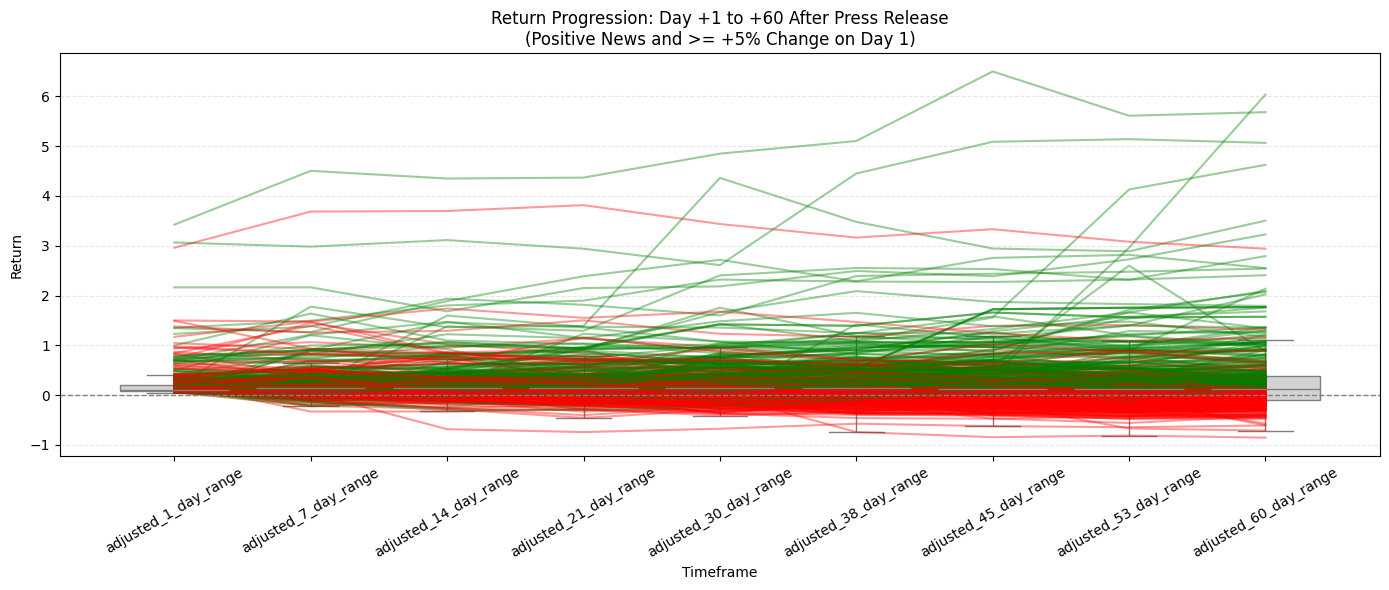

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

# --- Define the expanded day list ---
day_list = [1, 7, 14, 21, 30, 38, 45, 53, 60]
adjusted_columns = [f"adjusted_{day}_day_range" for day in day_list]

# --- Filter and clean data ---
plot_data = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == "Positive Results")
].copy()

plot_data['date'] = pd.to_datetime(plot_data['date'], format='%m_%d_%Y', errors='coerce')
plot_data = plot_data[
    (plot_data['date'].dt.year >= 2014) & (plot_data['date'].dt.year <= 2025)
][adjusted_columns]

plot_data = plot_data[
    (plot_data["adjusted_1_day_range"] >=  0.05)
].dropna().reset_index(drop=True)

# --- Identify change from Day 1 to Day 60 ---
plot_data["change"] = plot_data["adjusted_60_day_range"] - plot_data["adjusted_1_day_range"]
returns = plot_data["change"]
# --- EV & Power ---
long_ev = returns.mean()
long_ev_median = returns.median()
long_ev_25 = returns.quantile(0.25)
long_ev_75 = returns.quantile(0.75)

long_std = returns.std()
long_n = len(returns)
long_se = long_std / np.sqrt(long_n)
long_z = long_ev / long_se
long_power = stats.norm.cdf(long_z) if long_z > 0 else 1 - stats.norm.cdf(abs(long_z))

# Short is inverse of long
short_ev = -long_ev
short_ev_median = -long_ev_median
short_ev_25 = -long_ev_75  # note inversion for quantiles
short_ev_75 = -long_ev_25
short_std = long_std
short_se = long_se
short_z = short_ev / short_se
short_power = stats.norm.cdf(short_z) if short_z > 0 else 1 - stats.norm.cdf(abs(short_z))

# --- Confidence Interval Calculation (95%) ---
confidence_level = 0.95
z_critical = stats.norm.ppf(1 - (1 - confidence_level) / 2)

long_ci_low = long_ev - z_critical * long_se
long_ci_high = long_ev + z_critical * long_se
short_ci_low = short_ev - z_critical * short_se
short_ci_high = short_ev + z_critical * short_se

# --- Kelly Criterion ---
kelly_long = long_ev / (long_std ** 2) if long_std > 0 else 0
kelly_short = short_ev / (short_std ** 2) if short_std > 0 else 0
half_kelly_long = kelly_long / 2
half_kelly_short = kelly_short / 2

# --- Print Results ---
print(f"\n📊 Sample Size: {long_n}")

print("\n📈 Long Trade (Day 1 to 60):")
print(f"   Expected Value (Mean):   {long_ev:.4f}")
print(f"   25th Percentile:         {long_ev_25:.4f}")
print(f"   50th Percentile (Median): {long_ev_median:.4f}")
print(f"   75th Percentile:         {long_ev_75:.4f}")
print(" ")
print(f"   Std Dev:                 {long_std:.4f}")
print(f"   Z-score:                 {long_z:.2f}")
print(f"   Approx. Power:           {long_power:.2%}")
print(f"   95% CI:                  [{long_ci_low:.4f}, {long_ci_high:.4f}]")
if kelly_long > 0:
    print(f"\n   Kelly Fraction:          {kelly_long:.2%}")
    print(f"   Half Kelly:              {half_kelly_long:.2%}")
else:
    print("\n   Kelly: No bet suggested (negative EV)")

print("\n📉 Short Trade (Day 1 to 60):")
print(f"   Expected Value (Mean):   {short_ev:.4f}")
print(f"   25th Percentile:         {short_ev_25:.4f}")
print(f"   50th Percentile (Median): {short_ev_median:.4f}")
print(f"   75th Percentile:         {short_ev_75:.4f}")
print(" ")
print(f"   Std Dev:                 {short_std:.4f}")
print(f"   Z-score:                 {short_z:.2f}")
print(f"   Approx. Power:           {short_power:.2%}")
print(f"   95% CI:                  [{short_ci_low:.4f}, {short_ci_high:.4f}]")
if kelly_short > 0:
    print(f"\n   Kelly Fraction:          {kelly_short:.2%}")
    print(f"   Half Kelly:              {half_kelly_short:.2%}")
else:
    print("\n   Kelly: No bet suggested (negative EV)")


# --- Plot Progression ---
plot_data_long = plot_data.melt(
    id_vars="change",
    value_vars=adjusted_columns,
    var_name="Timeframe",
    value_name="Return"
)

plt.figure(figsize=(14, 6))
sns.boxplot(x="Timeframe", y="Return", data=plot_data_long, whis=1.5, fliersize=0, color="lightgray")

for i in range(len(plot_data)):
    values = [plot_data.loc[i, col] for col in adjusted_columns]
    color = 'green' if values[-1] > values[0] else ('red' if values[-1] < values[0] else 'gray')
    plt.plot(adjusted_columns, values, color=color, alpha=0.4)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Return Progression: Day +1 to +60 After Press Release\n(Positive News and >= +5% Change on Day 1)")
plt.ylabel("Return")
plt.xlabel("Timeframe")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Try running an actual backtest

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Define the expanded day list ---
day_list = [1, 7, 14, 21, 30, 38, 45, 53, 60]
adjusted_columns = [f"adjusted_{day}_day_range" for day in day_list]

# --- Function to simulate portfolio performance (with shorting capability) ---
def simulate_portfolio(plot_data, condition_label, initial_balance=10000, short=False):
    case_balance = initial_balance
    cash_balance = initial_balance  # Cash available for the case account

    # Create a list to track portfolio balances over time
    portfolio_records = []

    # Sort data by date
    plot_data = plot_data.sort_values(by='date')

    # Simulate the control account (S&P 500 investment)
    spy_returns = financial_data['SPY']['Close'].pct_change().fillna(0)
    spy_cumulative_returns = (1 + spy_returns).cumprod()

    # Iterate through the events for the case account
    for _, row in plot_data.iterrows():
        # Case account: Buy on Day 1 and sell on Day 60 (or short if specified)
        buy_date = row['date']
        sell_date = buy_date + pd.Timedelta(days=60)

        if sell_date in financial_data['SPY'].index:
            # Calculate the return for the case account
            buy_price = row['adjusted_1_day_range']
            sell_price = row['adjusted_60_day_range']
            trade_return = sell_price - buy_price

            # If shorting, reverse the trade return
            if short:
                trade_return = -trade_return

            # Determine the amount to invest (10% of the current portfolio balance)
            trade_amount = case_balance * 0.10

            # Only execute the trade if there is enough cash available
            if cash_balance >= trade_amount:
                # Update cash balance after the trade
                cash_balance -= trade_amount

                # Calculate the profit/loss from the trade and update the portfolio balance
                profit_loss = trade_amount * trade_return
                case_balance += profit_loss

                # Add the trade amount back to cash after selling
                cash_balance += trade_amount + profit_loss

        # Append balances to the portfolio records
        portfolio_records.append({
            'date': buy_date,
            f'{condition_label}_case_balance': case_balance
        })

    # Convert portfolio records to a DataFrame
    portfolio_df = pd.DataFrame(portfolio_records)

    # Remove duplicate dates by keeping the last entry for each date
    portfolio_df = portfolio_df.drop_duplicates(subset='date', keep='last')

    # Fill in missing dates and interpolate balances
    portfolio_df = portfolio_df.set_index('date').asfreq('D')  # Set daily frequency
    portfolio_df = portfolio_df.interpolate(method='linear')  # Interpolate missing values
    portfolio_df = portfolio_df.reset_index()

    return portfolio_df

# --- Calculate the control portfolio (S&P 500) for all dates ---
def calculate_control_portfolio(initial_balance=10000):
    spy_returns = financial_data['SPY']['Close'].pct_change().fillna(0)
    spy_cumulative_returns = (1 + spy_returns).cumprod().squeeze()  # Ensure this is a Series
    control_portfolio = pd.DataFrame({
        'date': spy_cumulative_returns.index,
        'control_balance': initial_balance * spy_cumulative_returns.values  # Use .values to ensure 1D array
    })
    return control_portfolio

# --- Filter and clean data for adjusted_1_day_range >= 0.05 ---
plot_data_positive = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == "Positive Results") &
    (df_expanded['adjusted_1_day_range'] >= 0.05)
].copy()
plot_data_positive['date'] = pd.to_datetime(plot_data_positive['date'], format='%m_%d_%Y', errors='coerce')

# Simulate portfolio for adjusted_1_day_range >= 0.05
portfolio_positive = simulate_portfolio(plot_data_positive, condition_label='positive')

# --- Filter and clean data for adjusted_1_day_range <= -0.05 ---
plot_data_negative = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == "Positive Results") &
    (df_expanded['adjusted_1_day_range'] <= -0.05)
].copy()
plot_data_negative['date'] = pd.to_datetime(plot_data_negative['date'], format='%m_%d_%Y', errors='coerce')

# Simulate portfolio for adjusted_1_day_range <= -0.05
portfolio_negative = simulate_portfolio(plot_data_negative, condition_label='negative')

# --- Filter and clean data for adjusted_1_day_range < 0 ---
plot_data_below_zero = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == "Positive Results") &
    (df_expanded['adjusted_1_day_range'] < 0)
].copy()
plot_data_below_zero['date'] = pd.to_datetime(plot_data_below_zero['date'], format='%m_%d_%Y', errors='coerce')

# Simulate portfolio for adjusted_1_day_range < 0
portfolio_below_zero = simulate_portfolio(plot_data_below_zero, condition_label='below_zero')

# --- Filter and clean data for adjusted_1_day_range > 0 ---
plot_data_above_zero = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == "Positive Results") &
    (df_expanded['adjusted_1_day_range'] > 0)
].copy()
plot_data_above_zero['date'] = pd.to_datetime(plot_data_above_zero['date'], format='%m_%d_%Y', errors='coerce')

# Simulate portfolio for adjusted_1_day_range > 0
portfolio_above_zero = simulate_portfolio(plot_data_above_zero, condition_label='above_zero')

# --- Filter and clean data for Mixed Results where adjusted_1_day_range >= 0 ---
plot_data_mixed_results = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == "Mixed Results")
].copy()
plot_data_mixed_results['date'] = pd.to_datetime(plot_data_mixed_results['date'], format='%m_%d_%Y', errors='coerce')

# Simulate portfolio for Mixed Results where adjusted_1_day_range >= 0
portfolio_mixed_results = simulate_portfolio(plot_data_mixed_results, condition_label='mixed_results', short=True)

# --- Calculate the control portfolio ---
control_portfolio = calculate_control_portfolio()

# --- Filter and clean data for Negative Results where adjusted_1_day_range <= -0.05 ---
plot_data_negative_short = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == "Negative Results")
].copy()
plot_data_negative_short['date'] = pd.to_datetime(plot_data_negative_short['date'], format='%m_%d_%Y', errors='coerce')

# Simulate portfolio for Negative Results (shorting)
portfolio_negative_short = simulate_portfolio(plot_data_negative_short, condition_label='negative_short', short=True)

# --- Merge the new portfolio with the existing ones ---
portfolio_combined = pd.merge(portfolio_positive, portfolio_negative, on='date', how='outer')
portfolio_combined = pd.merge(portfolio_combined, portfolio_below_zero, on='date', how='outer')
portfolio_combined = pd.merge(portfolio_combined, portfolio_above_zero, on='date', how='outer')
portfolio_combined = pd.merge(portfolio_combined, portfolio_mixed_results, on='date', how='outer')
portfolio_combined = pd.merge(portfolio_combined, portfolio_negative_results, on='date', how='outer')
portfolio_combined = pd.merge(portfolio_combined, portfolio_negative_short, on='date', how='outer')
portfolio_combined = pd.merge(portfolio_combined, control_portfolio, on='date', how='outer').sort_values(by='date')

# --- Interpolate missing values for smoothness ---
portfolio_combined = portfolio_combined.set_index('date').asfreq('D')  # Set daily frequency
portfolio_combined = portfolio_combined.interpolate(method='linear')  # Interpolate missing values
portfolio_combined = portfolio_combined.reset_index()

# --- Plot Portfolio Balances ---
plt.figure(figsize=(12, 6))
plt.plot(portfolio_combined['date'], portfolio_combined['below_zero_case_balance'], label='Long on Positive Results (w/ Price Increase on Day 1)', color='green')
plt.plot(portfolio_combined['date'], portfolio_combined['above_zero_case_balance'], label='Long on Positive Results (w/ Price Drop on Day 1)', color='purple')
plt.plot(portfolio_combined['date'], portfolio_combined['mixed_results_case_balance'], label='Short on Mixed Results (w/ Any Movement on Day 1)', color='brown')
plt.plot(portfolio_combined['date'], portfolio_combined['negative_results_case_balance'], label='Short on Negative Results (w/ Any Movement on Day 1)', color='black')
#plt.plot(portfolio_combined['date'], portfolio_combined['negative_short_case_balance'], label='Portfolio (Short on Negative Results)', color='pink')
plt.plot(portfolio_combined['date'], portfolio_combined['control_balance'], label='Control Portfolio (S&P 500)', color='orange')
plt.axhline(10000, color='gray', linestyle='--', label='Initial Balance ($10,000)')
#plt.title('Portfolio Balances Over Time')
#plt.xlabel('Date')
plt.ylabel('Portfolio Balance ($)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

NameError: name 'portfolio_negative_results' is not defined

# Developing ML Classifier to Predict Day 1 Range


In [52]:
# Filter the dataset
df_filtered = df_expanded[
    (df_expanded.event_type.isin(['Reporting Results & Data', 'Preliminary or Interim Results Shared'])) &
    (df_expanded.result_type == "Positive Results")
].copy()

# Drop specified columns from the dataset
columns_to_drop = [
    'additional_field', 'additional_fields', 'additional_notes', 'conclusion',
    'data', 'error', 'note', 'notes', 'null_field', 'other_field',
    'result_data', 'result_fields', 'year', 'description', "article_text"
]

# Ensure the columns exist before dropping
df_filtered = df_filtered.drop(columns=[col for col in columns_to_drop if col in df_filtered.columns], errors='ignore')

# Remove duplicate columns if any
df_filtered = df_filtered.loc[:, ~df_filtered.columns.duplicated()]

# Create a binary target column: 1 if 1_day_range > 0, else 0
df_filtered['target'] = (df_filtered['1_day_range'] > 0).astype(int)

# Expand 'drug_modalities' into one-hot encoded columns
if 'drug_modalities' in df_filtered.columns:
    # Explode the lists into separate rows
    df_filtered = df_filtered.explode('drug_modalities')
    
    # Filter for the specified drug modalities
    valid_modalities = ['small molecule', 'biologic', 'peptide', 'vaccine', 'oligonucleotide']
    df_filtered = df_filtered[df_filtered['drug_modalities'].isin(valid_modalities)]
    
    # Create one-hot encoded columns
    dummies = pd.get_dummies(df_filtered['drug_modalities'], prefix='drug_modalities')
    df_filtered = pd.concat([df_filtered, dummies], axis=1)
    
    # Drop the original column
    df_filtered = df_filtered.drop(columns=['drug_modalities'])

# Remove columns with unhashable types (e.g., lists or dictionaries)
for col in df_filtered.columns:
    if df_filtered[col].apply(lambda x: isinstance(x, (list, dict))).any():
        print(f"Dropping column with unhashable types: {col}")
        df_filtered = df_filtered.drop(columns=[col])

# Remove duplicate columns again after processing
df_filtered = df_filtered.loc[:, ~df_filtered.columns.duplicated()]

# Drop irrelevant columns
columns_to_exclude = ['article_id', 'ticker', 'date'] + \
    [col for col in df_filtered.columns if 'day_close' in col or 'day_range' in col or 'spy_range' in col]
X = df_filtered.drop(columns=columns_to_exclude + ['target'])
y = df_filtered['target']

# Handle categorical variables (one-hot encoding for remaining categorical columns)
X = pd.get_dummies(X, drop_first=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature importance using Recursive Feature Elimination (RFE)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)

# Get the most important features
important_features = X_train.columns[rfe.support_]
print("\nTop 10 Important Features:")
print(important_features)

Dropping column with unhashable types: additional_info
Dropping column with unhashable types: drug_or_treatment_names
Dropping column with unhashable types: fields
Dropping column with unhashable types: indications
Dropping column with unhashable types: therapeutic_areas
Accuracy: 0.531502423263328

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.34      0.41       292
           1       0.54      0.70      0.61       327

    accuracy                           0.53       619
   macro avg       0.52      0.52      0.51       619
weighted avg       0.53      0.53      0.52       619


Top 10 Important Features:
Index(['combination_or_monotherapy_combo', 'combination_or_monotherapy_mono',
       'how_data_is_shared_Paper Publication, Conference Presentation',
       'regulatory_action_type_Additional Data Requested',
       'regulatory_action_type_Conditional Marketing Authorization',
       'regulatory_action_type_Rolling Bio

In [53]:
from sklearn.model_selection import StratifiedKFold
from collections import Counter

# Perform 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
selected_features = []

for train_index, test_index in kf.split(X, y):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train a logistic regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    # Perform Recursive Feature Elimination (RFE)
    rfe = RFE(model, n_features_to_select=10)
    rfe.fit(X_train_scaled, y_train)
    
    # Get the selected features for this fold
    selected_features.extend(X_train.columns[rfe.support_])

# Count the occurrences of each feature across all folds
feature_counts = Counter(selected_features)

# Sort features by their frequency
most_common_features = feature_counts.most_common()

# Display the most common features
print("\nMost Common Features Across 10 Folds:")
for feature, count in most_common_features:
    print(f"{feature}: {count} times")


Most Common Features Across 10 Folds:
combination_or_monotherapy_combo: 10 times
combination_or_monotherapy_mono: 10 times
how_data_is_shared_Paper Publication, Conference Presentation: 10 times
regulatory_action_type_Supplemental Biologics License Application (sBLA): 10 times
market_cap_label_Small Cap: 10 times
regulatory_action_type_Rolling Biologics License Application (BLA) Submission: 8 times
regulatory_action_type_Supplemental New Drug Application (sBLA): 8 times
regulatory_body_Health Canada: 8 times
regulatory_action_type_Supplemental New Drug Application (sNDA): 8 times
regulatory_action_type_Marketing Authorization Application (MAA): 7 times
regulatory_action_type_Additional Data Requested: 6 times
regulatory_action_type_Traditional Approval: 3 times
regulatory_action_type_Breakthrough Therapy designation: 1 times
regulatory_action_type_Generic Approval: 1 times
